# MODULE 4 - EVALUATION

## 0. Data Preparation

In [1]:
# Imports
import pandas as pd
import numpy as np
import os
import wget as wget

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

Target variable -> converted

In [2]:
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"
folder = "04_evaluation/"

file = os.path.join(folder, "course_lead_scoring.csv")

wget.download(url, file)


'04_evaluation/course_lead_scoring (1).csv'

In [3]:
df = pd.read_csv(file)
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [201]:
for col in df.columns:
    print(col)
    print(df[col].unique()[:10])
    print(df[col].nunique())
    print()

lead_source
['paid_ads' 'social_media' 'events' 'referral' 'organic_search' nan]
5

industry
[nan 'retail' 'healthcare' 'education' 'manufacturing' 'technology'
 'other' 'finance']
7

number_of_courses_viewed
[1 5 2 3 0 4 6 8 7 9]
10

annual_income
[79450. 46992. 78796. 83843. 85012. 59904. 51283. 62975. 38648. 59866.]
1267

employment_status
['unemployed' 'employed' nan 'self_employed' 'student']
4

location
['south_america' 'australia' 'europe' 'africa' 'middle_east' nan
 'north_america' 'asia']
7

interaction_count
[4 1 3 6 2 0 5 7 9 8]
12

lead_score
[0.94 0.8  0.69 0.87 0.62 0.83 0.57 0.86 0.43 0.92]
101

converted
[1 0]
2



In [202]:
# Check nulls
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

If there are missing values:
* For caterogiral features, replace them with 'NA'
* For numerical features, replace with with 0.0

In [203]:
numerical = ['number_of_courses_viewed', 
             'annual_income', 
             'interaction_count', 
             'lead_score'
            ]

In [204]:
categorical = ['lead_source',
               'industry',
               'employment_status',
               'location',
              ]

In [205]:
# Replacing missing values

for c in categorical:
    df[c] = df[c].fillna('NA')

for n in numerical:
    df[n] = df[n].fillna(0)

df.converted = df.converted.astype(int).values

In [206]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NA,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NA,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [207]:
# Check nulls again
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [208]:
# Splitting data
ramdom_state = 1

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=ramdom_state)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=ramdom_state)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

## Q1. ROC AUC feature importance

In [209]:
from sklearn.metrics import roc_auc_score

In [210]:
auc_scores = {}

for col in numerical:
    auc = roc_auc_score(y_train, df_train[col])
    
    # Ifa AUC, 0.5, invert the variable
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col])
    
    auc_scores[col] = auc

# Show results
for col, auc in auc_scores.items():
    print(f"{col}: AUC = {auc:.4f}")


number_of_courses_viewed: AUC = 0.7636
annual_income: AUC = 0.5520
interaction_count: AUC = 0.7383
lead_score: AUC = 0.6145


In [211]:
# Best numerical feature
best_feature = max(auc_scores, key=auc_scores.get)
print(f"\nThe variable with higher AUC is: {best_feature}")


The variable with higher AUC is: number_of_courses_viewed


# Question 2: Training the model

Without Scalling numerical values

In [212]:
# Train function
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C= C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [213]:
# calculate predictions
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)    
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [214]:
dv, model = train(df_train, y_train, C=1.0)

In [215]:
y_pred = predict(df_val, dv, model)

In [216]:
# Calculate AUC
auc = roc_auc_score(y_val, y_pred)
round(auc, 3)

0.817

Scalling numerical values

In [217]:
from sklearn.preprocessing import StandardScaler

In [218]:
# Train function
def train_scalling(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    # Scaller
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    model = LogisticRegression(solver='liblinear', C= C, max_iter=1000)
    model.fit(X_train_scaled, y_train)
    
    return dv, scaler, model

In [219]:
# calculate predictions
def predict_scalling(df, dv, scaler, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    X_scaled = scaler.transform(X)
    
    y_pred = model.predict_proba(X_scaled)[:, 1]

    return y_pred

In [220]:
dv_scalling, scaler, model_scalling = train_scalling(df_train, y_train, C=1.0)

In [221]:
y_pred_scalling = predict_scalling(df_val, dv_scalling, scaler, model_scalling)

In [222]:
# Calculate AUC
auc_scalling = roc_auc_score(y_val, y_pred_scalling)
round(auc_scalling, 3)

0.921

# Question 3: Precision and Recall

Without Scalling numerical values

In [223]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [224]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

# p = tp / (tp + fp)
# r = tp / (tp + fn)

# df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
# df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

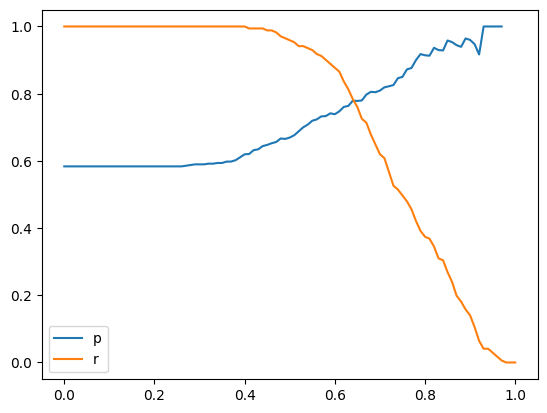

In [225]:
plt.plot(df_scores.threshold, df_scores['p'], label='p')
plt.plot(df_scores.threshold, df_scores['r'], label='r')
plt.legend()

In [226]:
# Min intersection
df_scores['p_r_intersect'] = abs(df_scores['p'] - df_scores['r'])
min_row = df_scores.loc[df_scores['p_r_intersect'].idxmin()]

print(min_row)

threshold          0.640000
tp               134.000000
fp                38.000000
fn                37.000000
tn                84.000000
p                  0.779070
r                  0.783626
p_r_intersect      0.004556
Name: 64, dtype: float64


Threshold precision and recall curves intersect at 0.64

Scalling numerical values

In [227]:
scores_scalling = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred_scalling >= t)
    predict_negative = (y_pred_scalling < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores_scalling.append((t, tp, fp, fn, tn))

In [228]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores_scalling = pd.DataFrame(scores_scalling, columns=columns)

df_scores_scalling['p'] = df_scores_scalling.tp / (df_scores_scalling.tp + df_scores_scalling.fp)
df_scores_scalling['r'] = df_scores_scalling.tp / (df_scores_scalling.tp + df_scores_scalling.fn)

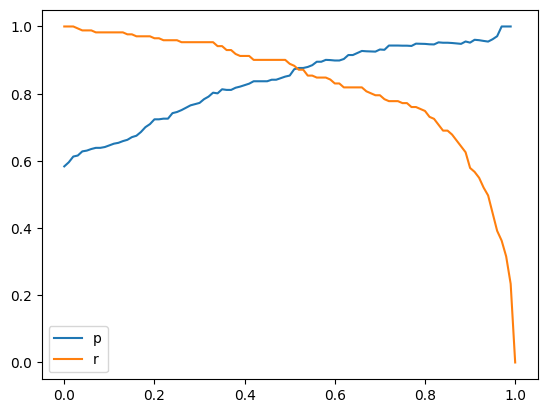

In [229]:
plt.plot(df_scores_scalling.threshold, df_scores_scalling['p'], label='p')
plt.plot(df_scores_scalling.threshold, df_scores_scalling['r'], label='r')
plt.legend()

In [230]:
# Min intersection
df_scores_scalling['p_r_intersect'] = abs(df_scores_scalling['p'] - df_scores_scalling['r'])
min_row = df_scores_scalling.loc[df_scores_scalling['p_r_intersect'].idxmin()]

print(min_row)

threshold          0.520000
tp               149.000000
fp                21.000000
fn                22.000000
tn               101.000000
p                  0.876471
r                  0.871345
p_r_intersect      0.005126
Name: 52, dtype: float64


Threshold precision and recall scalling numerical features curves intersect at 0.52

# Question 4: F1 score

Without Scalling numerical values

In [231]:
df_scores['f1'] = 2*(df_scores['p'] * df_scores['r'])/(df_scores['p'] + df_scores['r'])

In [232]:
max_f1_row = df_scores.loc[df_scores['f1'].idxmax()]

print(max_f1_row)

threshold          0.570000
tp               156.000000
fp                57.000000
fn                15.000000
tn                65.000000
p                  0.732394
r                  0.912281
p_r_intersect      0.179886
f1                 0.812500
Name: 57, dtype: float64


Scalling numerical values

In [233]:
df_scores_scalling['f1'] = 2*(df_scores_scalling['p'] * df_scores_scalling['r'])/(df_scores_scalling['p'] + df_scores_scalling['r'])

In [234]:
max_f1_row_scalling = df_scores_scalling.loc[df_scores_scalling['f1'].idxmax()]

print(max_f1_row_scalling)

threshold          0.510000
tp               151.000000
fp                22.000000
fn                20.000000
tn               100.000000
p                  0.872832
r                  0.883041
p_r_intersect      0.010209
f1                 0.877907
Name: 51, dtype: float64


# Question 5: 5-Fold CV

In [235]:
!pip install tqdm


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [236]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [237]:
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
C=1.0

Without Scalling numerical values

In [241]:
scores = []

for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv, model = train(df_train, y_train, C=C)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

0it [00:00, ?it/s]

C=1 0.822 +- 0.036


Scalling numerical values

In [238]:
scores_scalling = []

for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv, scaller, model = train_scalling(df_train, y_train, C=C)
    y_pred_scalling = predict_scalling(df_val, dv_scalling, scaler, model_scalling)

    auc = roc_auc_score(y_val, y_pred_scalling)
    scores_scalling.append(auc)

print('C=%s %.3f +- %.3f' % (C, np.mean(scores_scalling), np.std(scores_scalling)))

0it [00:00, ?it/s]

C=1.0 0.930 +- 0.009


# Question 6: Hyperparameter Tuning

Without Scalling numerical values

In [239]:
n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06 0.560 +- 0.024
C=0.001 0.867 +- 0.029
C=1 0.822 +- 0.036


Scalling numerical values

In [240]:
n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores_scalling = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.converted.values
        y_val = df_val.converted.values
    
        dv, scaller, model = train_scalling(df_train, y_train, C=C)
        y_pred_scalling = predict_scalling(df_val, dv_scalling, scaler, model_scalling)
    
        auc = roc_auc_score(y_val, y_pred_scalling)
        scores_scalling.append(auc)
    
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores_scalling), np.std(scores_scalling)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06 0.930 +- 0.009
C=0.001 0.930 +- 0.009
C=1 0.930 +- 0.009
